# Detecting marine heatwave based on observation

## What is marine heatwaves
The marine heatwaves are anomalous warm water over the ocean. 
To detect the warm ocean water, sea surface temperature (SST) is usually used to define if there is any marine heatwave event.

### Goals in the notes
- Extract the data from the PSL OPeNDAP server
- Calculate the SST climatology
- Calculate the SST anomaly 
- Determine the SST threshold based on the anomaly
- Identify the marine heatwaves based on threshold 

## Extract the data from the PSL OPeNDAP server
In this notebook, we demonstrate how to use the [NOAA OISST v2 High resolution dataset](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html) to show the observed marine heatwaves.
The dataset is currently hosted on [NOAA Physical Sciences Laboratory](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html).

````{margin}
```{tip}
To explore more gridded datasets that are hosted at NOAA PSL, here is a useful [search tool](https://psl.noaa.gov/data/gridded/index.html)
```
````

```{note}
The following example is following the paper [Jacox et al., 2022](http://doi.org/10.1038/s41586-022-04573-9). 
```

### Python modules
The module imported to the python kernel is shown below

In [1]:
import warnings
import datetime
import intake
import xarray as xr
import numpy as np

But for the binder/jupyternotebook to work, these are the list of required packages
```{note}
- numpy
- xarray
- dask
- netcdf4
- h5netcdf
- pydap
- scipy
- matplotlib
- intake
- intake-thredds
```
Some of the packages are used in the backend of the imported packaged shown above.


### Utilize intake for thredds
The thredds catalog can be viewed with the intake and intake-thredds module. 
This is not actually needed for downloading the data since PSL data server also provide the [OPeNDAP](https://www.earthdata.nasa.gov/engage/open-data-services-and-software/api/opendap) approach. 
Here, we are just demostrating a great way to generate a list of file names that can be seen in the thredds catalog.

In [2]:
cat_url = 'https://psl.noaa.gov/thredds/catalog/Datasets/noaa.oisst.v2.highres/catalog.xml'
catalog = intake.open_thredds_cat(cat_url, name='noaa-oisst')
catalog

noaa-oisst:
  args:
    name: noaa-oisst
    url: https://psl.noaa.gov/thredds/catalog/Datasets/noaa.oisst.v2.highres/catalog.xml
  description: ''
  driver: intake_thredds.cat.ThreddsCatalog
  metadata:
    dataType: Grid
    inherited: true
    serviceName: all


In [3]:
list(catalog)[-10:]

['sst.day.mean.2022.nc',
 'sst.day.mean.2022.v2.nc',
 'sst.day.mean.2023.nc',
 'sst.day.mean.ltm.1971-2000.nc',
 'sst.day.mean.ltm.1982-2010.nc',
 'sst.day.mean.ltm.1991-2020.nc',
 'sst.day.mean.ltm.nc',
 'sst.mon.ltm.1991-2020.nc',
 'sst.mon.mean.nc',
 'sst.week.mean.nc']

````{margin}
```{tip}
For more information, [intake-thredds readthedoc](https://intake-thredds.readthedocs.io/en/latest/tutorials/index.html) shows how to access data using dask from intake
```
````

### Lazy loading the dataset through OPeNDAP
With the power of [Xarray](https://docs.xarray.dev/en/stable/) and [Dask](https://www.dask.org), we are able to load the data lazily (only loading the meta data and coordinates information) and peek at data's dimension and availability on our local machine.
The actual data (SST values at each grid point in this case) will only be downloaded from the PSL server when further data manipulation (subsetting and aggregation like calculating mean) is needed.
The lazy loading approach provides the oppurtunity to reduce the memory usage in the calculation, the possibility of parallizing the processes, and side stepping the data download limit set by OPeNDAP server (PSL server has a 500MB limit).

In [4]:
opendap_mon_url = "https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/sst.mon.mean.nc"

ds_mon = xr.open_dataset(opendap_mon_url, engine='pydap', chunks={'time':12,'lon':-1,'lat':-1})

```{important}
The `chunks` keyward argument in the `open_dataset` is the key to your processing speed and how one avoid the download limit of OPeNDAP server. 

The `engine` keyward argument is set to `'pydap'` to utilize the pydap backend to grab the data on a OPeNDAP server.
```
#### What is chunk?
Dask has a great [documentation](https://docs.dask.org/en/latest/array-chunks.html) of chunks. The basic idea is that a single netCDF file can be seperated into multiple chunks (e.g. 20(lon)x20(lat) into four chunks of 10(lon)x10(lat)). 
By reading each chunk at a time as needed, we do not have to load the entire dataset into the memory.
This chunk by chunk reading is performed by Dask in the background. 
The only thing user need to do to activate this lazy loding approach is to read the netCDF file using the `xr.open_dataset()` method with the keyword argument `chunks={'time':12,'lon':-1,'lat':-1}` provided.
The dataset is loaded lazily (only meta data and coordinates) shown below.

In [5]:
ds_mon

<xarray.Dataset>
Dimensions:  (time: 484, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-12-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(12, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.5
    title:                           NOAA/NCEI 1/4 Degree Daily Optimum Inter...
    institution:                     NOAA/National Centers for Environmental ...
    source:                          NOAA/NCEI https://www.ncei.noaa.gov/data...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    dataset_title:                   NOAA Daily Optimum Interpolation Sea Sur...
    version:                         Version 2.1
    comment:                         Reynolds, et al.(2007) Daily High-Resolu...
    _NCProperties:                   version=2,netcdf=4.7.0,hdf5=1.10.5,
    DODS_EXTRA.Unlimited_Dimension:  time

In our example, we set the size of each chunk to be 12(time)x1440(lon)x720(lat) which is equal to 47.46 MB of data while the entire dataset is 1.39 GB. 
This allow us to get data in 47.46 MB chunk per download request.

## Calculate the SST climatology
First, we need to define the period that we are going to use to calculate the climatology.
Here, we picked 2010-2020 period to calculate the climatology.
```{important}
For a more accurate and scientificly valid estimate of marine heatwaves, one should usually consider a climatology period of at least 30 years.
Here we set the climatology period from 2010 to 2020 (10years) to speed up the processing time and for demostration only. 
The shorter period (smaller memory consumption) also make the binder launch on this page available for user to manipulate and play with the dataset. 
```

In [6]:
climo_start_yr = 2010             # determine the climatology/linear trend start year
climo_end_yr = 2020               # determine the climatology/linear trend end year

ds_mon_crop = ds_mon.where((ds_mon['time.year']>=climo_start_yr)&
                           (ds_mon['time.year']<=climo_end_yr),drop=True)

ds_mon_crop

<xarray.Dataset>
Dimensions:  (time: 132, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2020-12-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(8, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.5
    title:                           NOAA/NCEI 1/4 Degree Daily Optimum Inter...
    institution:                     NOAA/National Centers for Environmental ...
    source:                          NOAA/NCEI https://www.ncei.noaa.gov/data...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    dataset_title:                   NOAA Daily Optimum Interpolation Sea Sur...
    version:                         Version 2.1
    comment:                         Reynolds, et al.(2007) Daily High-Resolu...
    _NCProperties:                   version=2,netcdf=4.7.0,hdf5=1.10.5,
    DODS_EXTRA.Unlimited_Dimension:  time

To calculate the SST monthly climatology, we can utilize the `groupby` method from Xarray.

In [7]:
ds_mon_climo = ds_mon_crop.groupby('time.month').mean()

## Calculate the SST anomaly
After the climatology is determined, we substract the climatology from the original data to get the anomaly.

In [8]:
ds_mon_anom = (ds_mon_crop.groupby('time.month')-ds_mon_climo).compute()
ds_mon_anom.sst

<xarray.DataArray 'sst' (time: 132, lat: 720, lon: 1440)>
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [-3.1319499e-02, -2.7741909e-02, -2.6187658e-02, ...,
         -2.6598334e-02, -2.7155399e-02, -3.1085014e-02],
        [-2.4809241e-02, -1.8386960e-02, -1.6305089e-02, ...,
         -1.4369369e-02, -1.4985323e-02, -2.3841619e-02],
        [-5.4544210e-03, -5.9822798e-03, -6.4514875e-03, ...,
         -8.2111359e-03, -7.2433949e-03, -6.1584711e-03]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
...
        [ 5.2757502e-02,  4.2848587e-02,  3.7666678e-02, ...,
          2.0515203e-02,  2.8000116e-02,  4.2333364e-02],
        [ 3.1303048e-02,  9.6969604e-03, -1.5139580e-04, ...,
         -6.9090128e-03, -9.0956688e-05,  2.0666718e-02],
        [-3.4575701e-02, -3.4575701e-02, -2.1000028e-02, ...,
         -2.6000023e-02, -3.4575701e-02, -3.4575701e-02]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [ 1.6598463e-02,  8.3285570e-03,  4.1640997e-03, ...,
          7.9178810e-04,  3.4604073e-03,  1.1348963e-02],
        [ 6.4809322e-03, -8.3577633e-03, -1.6686082e-02, ...,
         -1.5073180e-02, -1.3401747e-02,  1.7619133e-04],
        [-3.0703783e-02, -3.0703783e-02, -3.0703783e-02, ...,
         -3.0703783e-02, -3.0703783e-02, -3.0703783e-02]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2020-12-01
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

```{attention}
Notice the `.compute()` method in the code above.
The data of SST is only loaded in chunk, cropped to the desired period, averaged in group of month, and finally subtracted the climatology from the original data when we type compute.
All these tasks are now executed in the background with distrbuted server assigning tasks to different CPUs. 
```

## Determine the SST threshold based on the anomaly
Normally, the monthly threshold can be calculated using a oneliner if the threshold is only based on the same month (e.g. January threshold is determined by all January SST anomaly).

In [9]:
ds_mon_anom.sst.groupby('time.month').quantile(0.95,dim='time')

/home/chsu/miniconda3/envs/boto3-jupyterbook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


<xarray.DataArray 'sst' (month: 12, lat: 720, lon: 1440)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.02835792, 0.03064525, 0.03655434, ..., 0.03759527,
         0.03155434, 0.0287537 ],
        [0.02761012, 0.0340324 , 0.03611428, ..., 0.03805   ,
         0.03743404, 0.02857774],
        [0.04567462, 0.04514676, 0.04467756, ..., 0.04695022,
         0.04388565, 0.04497057]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [0.0959242 , 0.07951522, 0.07316673, ..., 0.05734849,
         0.06800008, 0.0875001 ],
        [0.06330305, 0.03903037, 0.03834862, ..., 0.03659099,
         0.04340905, 0.05600005],
        [0.05225766, 0.05225766, 0.04883337, ..., 0.05050004,
         0.05225766, 0.05225766]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.07546937, 0.05752206, 0.05255127, ..., 0.05224347,
         0.05668616, 0.07215536],
        [0.04615831, 0.03131968, 0.03976554, ..., 0.03847522,
         0.03256601, 0.0459826 ],
        [0.05300587, 0.05300587, 0.05300587, ..., 0.05300587,
         0.05300587, 0.05300587]]])
Coordinates:
  * lat       (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
    quantile  float64 0.95
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

However, based on the research, the threshold is determined based on a three month window with the center month being the threhold month one need to determined (e.g. January threshold is determined by all December, January, Feburary SST anomaly). 
Therefore, the function below is written to perform the three months window percentile operation.

In [10]:
########## Functions ######### 
# Function to calculate the 3 month rolling Quantile
def mj_3mon_quantile(da_data, mhw_threshold=90.):
    
    da_data_quantile = xr.DataArray(coords={'lon':da_data.lon,
                                            'lat':da_data.lat,
                                            'month':np.arange(1,13)},
                                    dims = ['month','lat','lon'])

    for i in range(1,13):
        if i == 1:
            mon_range = [12,1,2]
        elif i == 12 :
            mon_range = [11,12,1]
        else:
            mon_range = [i-1,i,i+1]

        da_data_quantile[i-1,:,:] = (da_data
                                 .where((da_data['time.month'] == mon_range[0])|
                                        (da_data['time.month'] == mon_range[1])|
                                        (da_data['time.month'] == mon_range[2]),drop=True)
                                 .quantile(mhw_threshold*0.01, dim = 'time', skipna = True))

    return da_data_quantile

In [11]:
%time da_mon_quantile = mj_3mon_quantile(ds_mon_anom.sst, mhw_threshold=90)

/home/chsu/miniconda3/envs/boto3-jupyterbook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/home/chsu/miniconda3/envs/boto3-jupyterbook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/home/chsu/miniconda3/envs/boto3-jupyterbook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/home/chsu/miniconda3/envs/boto3-jupyterbook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/home/chsu/miniconda3/envs/boto3-jupyterbook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/home/chsu/miniconda3/envs/boto3-jupyterbook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/home/chsu/miniconda3/envs/boto3-jupyterbook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/home/chsu/miniconda3/envs/boto3-jupyterbook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/home/chsu/miniconda3/envs/boto3-jupyterbook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/home/chsu/miniconda3/envs/boto3-jupyterbook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/home/chsu/miniconda3/envs/boto3-jupyterbook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/home/chsu/miniconda3/envs/boto3-jupyterbook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


CPU times: user 8min 36s, sys: 9.58 s, total: 8min 46s
Wall time: 8min 49s


```{tip}
the `%time` command is jupyter cell magic to time the one-liner cell operation which provide a great way to find bottleneck of your data processing steps.
```

The determined threshold value of each grid of each month is shown below

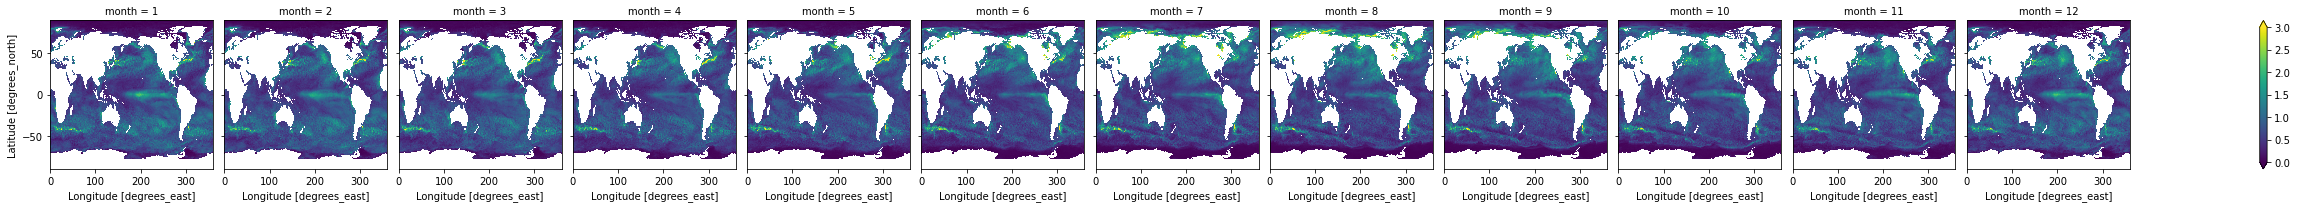

In [12]:
da_mon_quantile.plot(col='month',vmin=0,vmax=3)

## Identify the marine heatwaves based on threshold 
The figure below shows the original SST anomly value for the first 12 month

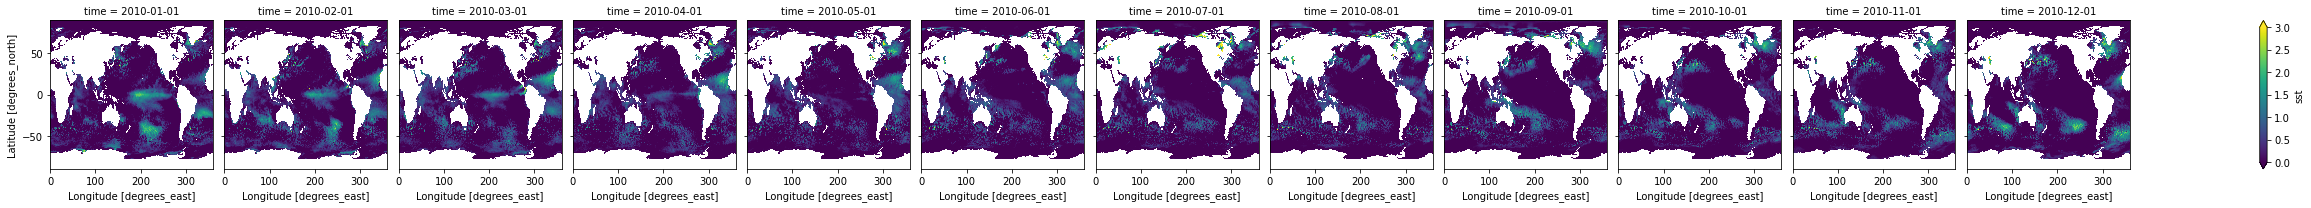

In [13]:
ds_mon_anom.sst.isel(time=slice(0,12)).plot(col='time',vmin=0,vmax=3)

To identify the marine heatwaves based on the monthly threshold that we just determined, we again use a one-liner code to find the monthly marine heatwaves with the grid that has SST anomaly below threshold to be masked as Not-a-Number.

In [14]:
da_mhw = ds_mon_anom.sst.where(ds_mon_anom.sst.groupby('time.month')>da_mon_quantile)

The figure below shows the SST anomly values that are above the monthly thresholds for the first 12 month

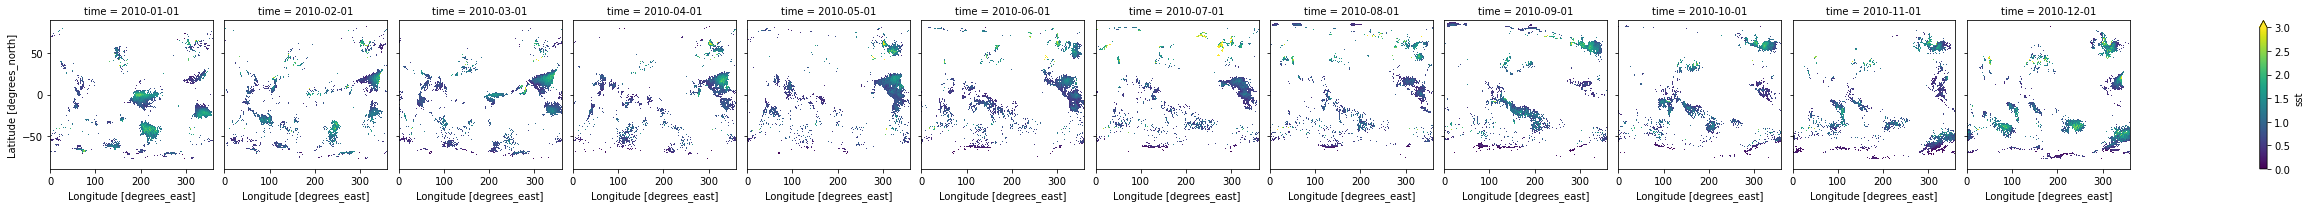

In [15]:
da_mhw.isel(time=slice(0,12)).plot(col='time',vmin=0,vmax=3)